### OLID

In [1]:
import numpy as np
import pandas as pd
import tqdm as tqdm
import torch
import sys
import os
import importlib

sys.path.append(os.path.abspath("../"))  # Add directory
import eval_metrics  # Import module

# Reload if modified
importlib.reload(eval_metrics)
from eval_metrics import evaluate_model, custom_threshold_condition

In [2]:
from datasets import load_dataset

ds = load_dataset("christophsonntag/OLID")

In [3]:
o_train = ds['train'].to_pandas()
o_test = ds['test'].to_pandas()
olid = pd.concat([o_train, o_test])
olid.head()

,id,tweet,cleaned_tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,ask native americans take,OFF,UNT,None
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home drunk maga trump 2020,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,amazon investigating chinese employees selling...,NOT,None,None
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone vetaken piece shit volcano,OFF,UNT,None
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama wanted liberals illegals move red states,NOT,None,None


In [4]:
## Check the number of offensive and non offensive tweets in the dataset
olid['subtask_a'].value_counts()

subtask_a
NOT    9460
OFF    4640
Name: count, dtype: int64

In [4]:
olid['true_label'] = olid['subtask_a'].map({'NOT': 0, 'OFF': 1})
olid.head()

,id,tweet,cleaned_tweet,subtask_a,subtask_b,subtask_c,true_label
0,86426,@USER She should ask a few native Americans wh...,ask native americans take,OFF,UNT,None,1
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home drunk maga trump 2020,OFF,TIN,IND,1
2,16820,Amazon is investigating Chinese employees who ...,amazon investigating chinese employees selling...,NOT,None,None,0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone vetaken piece shit volcano,OFF,UNT,None,1
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama wanted liberals illegals move red states,NOT,None,None,0


### Cardiffnlp/Twitter-Roberta-Base-Offensive

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-offensive")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-offensive")

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

d:\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\hf_cache\hub\models--cardiffnlp--twitter-roberta-base-offensive. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [27]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm import tqdm

max_length = 512
# Device (GPU or CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

# Prediction function
def predict_offensive(tweets, batch_size=32):
    predictions, scores = [], []
    for i in tqdm(range(0, len(tweets), batch_size)):
        batch = tweets[i:i+batch_size].tolist()
        encoded = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**encoded)
            probs = softmax(outputs.logits.cpu().numpy(), axis=1)
            preds = probs.argmax(axis=1)
            predictions.extend(preds)
            scores.extend(probs[:, 1])  # Offensive probability
    return predictions, scores

# Apply prediction on your olid DataFrame
olid['pred'], olid['offensive_prob'] = predict_offensive(olid['tweet'])

# Map predictions to labels
labels = {0: 'Not Offensive', 1: 'Offensive'}
olid['pred_label'] = olid['pred'].map(labels)

# Check results
olid.head()


100%|██████████| 441/441 [03:23<00:00,  2.17it/s]


,id,tweet,cleaned_tweet,subtask_a,subtask_b,subtask_c,pred,offensive_prob,pred_label
0,86426,@USER She should ask a few native Americans wh...,ask native americans take,OFF,UNT,None,0,0.149674,Not Offensive
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home drunk maga trump 2020,OFF,TIN,IND,1,0.798747,Offensive
2,16820,Amazon is investigating Chinese employees who ...,amazon investigating chinese employees selling...,NOT,None,None,0,0.086544,Not Offensive
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone vetaken piece shit volcano,OFF,UNT,None,1,0.875503,Offensive
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama wanted liberals illegals move red states,NOT,None,None,0,0.369900,Not Offensive


In [33]:
olid.to_csv('olid_cardiffnlp_roberta.csv', index=False)


📊 Classification Report:
               precision    recall  f1-score   support

Not Offensive       0.88      0.90      0.89      9460
    Offensive       0.79      0.76      0.78      4640

     accuracy                           0.86     14100
    macro avg       0.84      0.83      0.83     14100
 weighted avg       0.85      0.86      0.86     14100


✅ Accuracy: 0.8560
✅ Precision: 0.7947
✅ Recall: 0.7582
✅ F1 Score: 0.7760


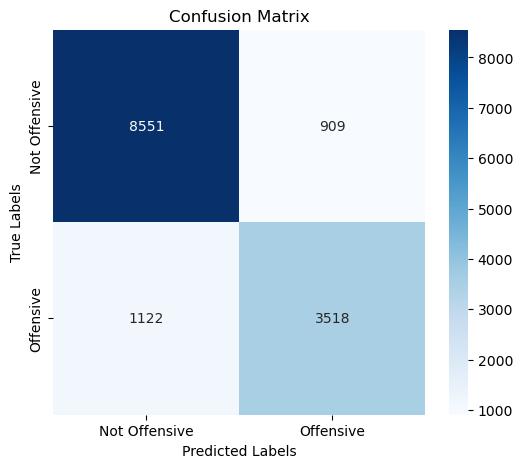

In [32]:
# Threshold=0.5
evaluate_model(olid['true_label'].to_numpy(),y_pred=olid['pred'],class_labels=['Not Offensive','Offensive'],threshold=0.5)

### Silvglad/DistilRoberta

In [36]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
model = AutoModelForSequenceClassification.from_pretrained("silvglad/distilroberta-olid-lr5e5-wd001")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

d:\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\hf_cache\hub\models--distilroberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [37]:
from scipy.special import softmax
from tqdm import tqdm

model.to(device)
model.eval()

def predict_offensive(tweets, batch_size=32):
    predictions, scores = [], []
    for i in tqdm(range(0, len(tweets), batch_size)):
        batch = tweets[i:i+batch_size].tolist()
        encoded = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**encoded)
            probs = softmax(outputs.logits.cpu().numpy(), axis=1)
            preds = probs.argmax(axis=1)
            predictions.extend(preds)
            scores.extend(probs[:, 1])  # Offensive probability
    return predictions, scores

# Apply prediction on your olid DataFrame
olid['pred'], olid['offensive_prob'] = predict_offensive(olid['tweet'])

# Map predictions to labels
labels = {0: 'Not Offensive', 1: 'Offensive',2: 'Offensive',3: 'Offensive',4:'Offensive'}
olid['pred_label'] = olid['pred'].map(labels)

# Check results
olid.head()

100%|██████████| 441/441 [01:44<00:00,  4.23it/s]


,id,tweet,cleaned_tweet,subtask_a,subtask_b,subtask_c,pred,offensive_prob,pred_label,true_label
0,86426,@USER She should ask a few native Americans wh...,ask native americans take,OFF,UNT,None,0,0.004189,Not Offensive,1
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home drunk maga trump 2020,OFF,TIN,IND,4,0.024994,Offensive,1
2,16820,Amazon is investigating Chinese employees who ...,amazon investigating chinese employees selling...,NOT,None,None,0,0.003921,Not Offensive,0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone vetaken piece shit volcano,OFF,UNT,None,4,0.186175,Offensive,1
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama wanted liberals illegals move red states,NOT,None,None,0,0.019992,Not Offensive,0


In [38]:
olid['pred']= olid['pred_label'].map({"Not Offensive":0,"Offensive":1})
olid.head()

,id,tweet,cleaned_tweet,subtask_a,subtask_b,subtask_c,pred,offensive_prob,pred_label,true_label
0,86426,@USER She should ask a few native Americans wh...,ask native americans take,OFF,UNT,None,0,0.004189,Not Offensive,1
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home drunk maga trump 2020,OFF,TIN,IND,1,0.024994,Offensive,1
2,16820,Amazon is investigating Chinese employees who ...,amazon investigating chinese employees selling...,NOT,None,None,0,0.003921,Not Offensive,0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone vetaken piece shit volcano,OFF,UNT,None,1,0.186175,Offensive,1
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama wanted liberals illegals move red states,NOT,None,None,0,0.019992,Not Offensive,0


Accuracy: 0.855177304964539
F1-score: 0.7701485817199459


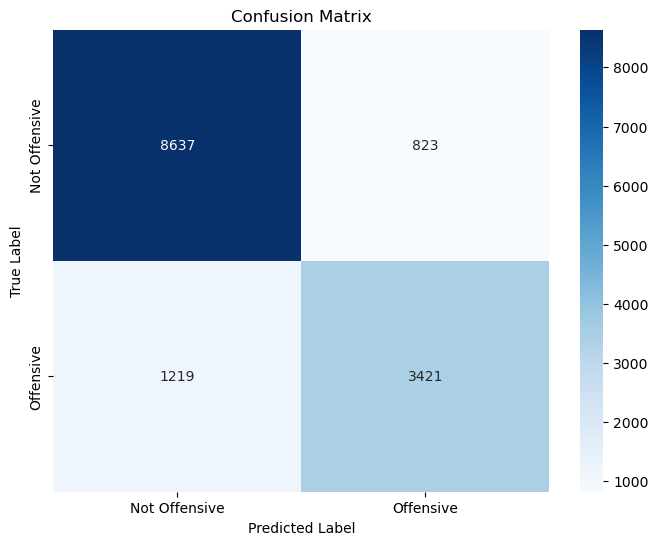

In [41]:
# prompt: calclulate acc and f1 and also plot a good looking confusion matrix. true label: tweeteval['label'], pred_label: tweeteval['pred']

from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate accuracy and F1-score
accuracy = accuracy_score(olid['true_label'], olid['pred'])
f1 = f1_score(olid['true_label'], olid['pred'])

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

# Create confusion matrix
cm = confusion_matrix(olid['true_label'], olid['pred'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Offensive', 'Offensive'],
            yticklabels=['Not Offensive', 'Offensive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Arash Rasouli Bert

In [14]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("arash-rasouli/BERT-offensive-tweet-classification")

In [15]:
import torch
import pandas as pd
from scipy.special import softmax
from tqdm import tqdm

max_length = 512
# Device (GPU or CPU)
device ="cpu"
model.to(device)
model.eval()

# Prediction function
def predict_offensive(tweets, batch_size=32):
    predictions, scores = [], []
    for i in tqdm(range(0, len(tweets), batch_size)):
        batch = tweets[i:i+batch_size].tolist()
        encoded = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**encoded)
            probs = softmax(outputs.logits.cpu().numpy(), axis=1)
            preds = probs.argmax(axis=1)
            predictions.extend(preds)
            scores.extend(probs[:, 1])  # Offensive probability
    return predictions, scores

# Apply prediction on your olid DataFrame
olid['pred'], olid['offensive_prob'] = predict_offensive(olid['tweet'])

# Map predictions to labels
labels = {0: 'Not Offensive', 1: 'Offensive'}
olid['pred_label'] = olid['pred'].map(labels)

# Check results
olid.head()


100%|██████████| 441/441 [22:41<00:00,  3.09s/it]


,id,tweet,cleaned_tweet,subtask_a,subtask_b,subtask_c,pred,offensive_prob,pred_label
0,86426,@USER She should ask a few native Americans wh...,ask native americans take,OFF,UNT,None,0,0.020834,Not Offensive
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home drunk maga trump 2020,OFF,TIN,IND,1,0.749883,Offensive
2,16820,Amazon is investigating Chinese employees who ...,amazon investigating chinese employees selling...,NOT,None,None,0,0.018692,Not Offensive
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone vetaken piece shit volcano,OFF,UNT,None,1,0.979588,Offensive
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama wanted liberals illegals move red states,NOT,None,None,0,0.130298,Not Offensive



📊 Classification Report:
               precision    recall  f1-score   support

Not Offensive       0.90      0.93      0.92      9460
    Offensive       0.86      0.80      0.83      4640

     accuracy                           0.89     14100
    macro avg       0.88      0.87      0.87     14100
 weighted avg       0.89      0.89      0.89     14100


✅ Accuracy: 0.8896
✅ Precision: 0.8566
✅ Recall: 0.7983
✅ F1 Score: 0.8264


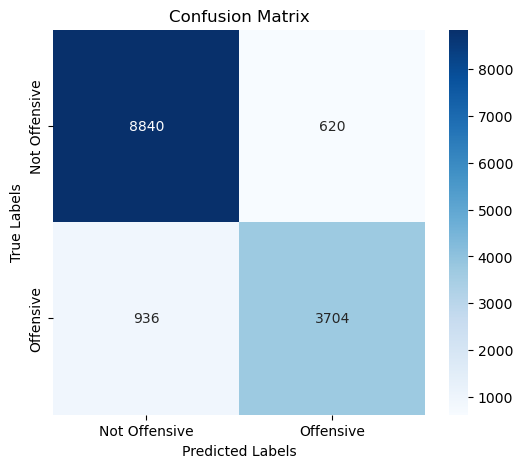

In [18]:
# Threshold=0.5
evaluate_model(olid['true_label'].to_numpy(),y_pred=olid['pred'].to_numpy(),class_labels=['Not Offensive','Offensive'],threshold=0.5)

In [19]:
olid.to_csv('tweeteval_arash_bert.csv',index=False)

### Tasksource/Deberta

In [5]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm

def load_zero_shot_classifier(model_name="tasksource/deberta-small-long-nli"):
    """
    Loads a zero-shot classification pipeline with the specified model.
    """
    # Specify the task for zero-shot classification
    classifier = pipeline("zero-shot-classification", model=model_name,device='cuda')
    return classifier

def classify_tweets(df, text_column="tweet", candidate_labels=None, batch_size=16):
    """
    Classifies tweets in a DataFrame using a zero-shot classification pipeline.
    
    Args:
        df (pd.DataFrame): DataFrame containing tweets.
        text_column (str): Name of the column containing tweet texts.
        candidate_labels (list): List of candidate labels.
        batch_size (int): Batch size for processing (pipeline processes one tweet at a time).
        
    Returns:
        DataFrame with an added 'prediction' column.
    """
    if candidate_labels is None:
        # Default candidate labels; adjust as needed
        candidate_labels = ["Not Offensive", "Offensive"]
        
    classifier = load_zero_shot_classifier()
    predictions = []
    tweets = df[text_column].tolist()
    
    for i in tqdm(range(0, len(tweets), batch_size), desc="Classifying tweets"):
        batch = tweets[i:i+batch_size]
        # Process each tweet in the batch individually
        for tweet in batch:
            result = classifier(tweet, candidate_labels=candidate_labels)
            # Take the label with the highest score
            predictions.append(result["labels"][0])
    
    df["prediction"] = predictions
    return df

# Example usage:
if __name__ == "__main__":
    # Load your dataset (ensure your CSV has a column named "tweet")
    candidate_labels = ["Not Offensive", "Offensive"]
    classified_df = classify_tweets(olid, text_column="tweet", candidate_labels=candidate_labels, batch_size=32)
    classified_df.head()


Device set to use cuda
Classifying tweets:   0%|          | 0/441 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Classifying tweets: 100%|██████████| 441/441 [12:25<00:00,  1.69s/it]


In [9]:
classified_df['pred_label'] = classified_df['prediction'].map({'Not Offensive': 0, 'Offensive': 1})
classified_df.head()

,id,tweet,cleaned_tweet,subtask_a,subtask_b,subtask_c,true_label,prediction,pred_label
0,86426,@USER She should ask a few native Americans wh...,ask native americans take,OFF,UNT,None,1,Not Offensive,0
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home drunk maga trump 2020,OFF,TIN,IND,1,Offensive,1
2,16820,Amazon is investigating Chinese employees who ...,amazon investigating chinese employees selling...,NOT,None,None,0,Not Offensive,0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone vetaken piece shit volcano,OFF,UNT,None,1,Offensive,1
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama wanted liberals illegals move red states,NOT,None,None,0,Offensive,1


In [10]:
classified_df.to_csv('tweeteval_tasksource_deberta.csv',index=False)


📊 Classification Report:
               precision    recall  f1-score   support

Not Offensive       0.88      0.73      0.80      9460
    Offensive       0.59      0.79      0.68      4640

     accuracy                           0.75     14100
    macro avg       0.74      0.76      0.74     14100
 weighted avg       0.78      0.75      0.76     14100


✅ Accuracy: 0.7530
✅ Precision: 0.5937
✅ Recall: 0.7907
✅ F1 Score: 0.6782


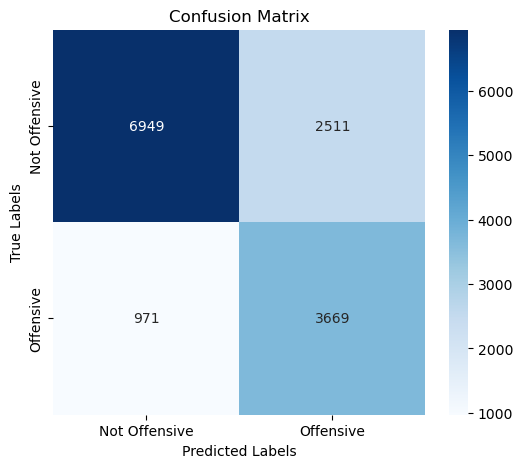

In [11]:
evaluate_model(classified_df['true_label'].to_numpy(),y_pred=classified_df['pred_label'].to_numpy(),class_labels=['Not Offensive','Offensive'],threshold=0.5)